# Ordinary Exam 2023 - Dynamic strategies

# Guided Solution


Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving both problems. 

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

In [2]:
# numpy for working with matrices, etc. 
import numpy as np

# import pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# scipy for statistics and optimization 
from scipy import optimize
from scipy import stats


"""
functions from codelib
"""

# functions for calculating moments
import codelib.statistics.moments as mom
# functions for calculating risk metrics
import codelib.portfolio_optimization.risk_metrics as rm
# predefined plots
from codelib.visualization.base import fan_chart

# Problem 1: Buy-and-hold versus constant-mix portfolios

## Modelling the "market" 

We have assumed that the two risky investment follows a Geometric Brownian motion 

$$
dV_t^1 = V_{1,t} \mu_1 dt + \sigma_1 V_{1,t} dZ_{1,t}
$$

$$
dV_{2,t} = V_{2,t} \mu_2 dt + \sigma_2 V_{2,t} (\rho dZ_{1,t} + \sqrt{1 - \rho^2} dZ_{2,t})
$$

which can equivalently be written as 

$$
d \log V_{1,t} = (\mu_1 - \sigma_1^2 / 2) dt + \sigma_1 dZ_{1,t}
$$

$$
d \log V_{2,t} = (\mu_2 - \sigma_2^2 / 2) dt + \sigma_2 (\rho dZ_{1,t} + \sqrt{1 - \rho^2}  dZ_{2,t})
$$

In [3]:
"""
Parameter assumptions
"""
mu1 = 0.03
mu2 = 0.06
sigma1 = 0.075
sigma2 = 0.15
rho = 0.2

# store values in vector and matrices
mu = np.array([mu1, mu2])
vols = np.array([sigma1, sigma2])
corr_mat = np.array([[1.0, rho],
                     [rho, 1.0]])

# define covariance matrix
cov_mat = mom.corr_to_cov_matrix(corr_mat, vols)

# investment horizon 
horizon = 5.0

In [4]:
cov_mat

array([[0.005625, 0.00225 ],
       [0.00225 , 0.0225  ]])

### Instantaneous correlation between log-returns of the two risky assets 

$$
\begin{align}
\text{Corr}[d\log V_{1,t}, d \log V_{2,t}] &= \frac{\text{E}[\sigma_1 dZ_{1,t} \sigma_2 (\rho dZ_{1,t} + \sqrt{1 - \rho^2}  dZ_{2,t})]}{\sqrt{\text{E}[\sigma_1^2 dZ_{1,t}^2 ] \text{E}[\sigma_2^2(\rho dZ_{1,t} + \sqrt{1 - \rho^2}  dZ_{2,t})^2]}} \\
&= \frac{\sigma_1 \sigma_2 (\rho \text{E}[dZ_{1,t}^2]  + \sqrt{1 - \rho^2}  \text{E}[dZ_{1,t}dZ_{2,t}])}{\sqrt{\sigma_1^2 \text{E}[dZ_{1,t}^2]  \sigma_2^2(\rho^2 \text{E}[dZ_{1,t}^2] + (1 - \rho^2)  \text{E}[dZ_{2,t}^2]]}} \\
&= \frac{\sigma_1 \sigma_2 \rho dt}{\sqrt{\sigma_1^2 dt  \sigma_2^2dt}} \\
&= \rho
\end{align}
$$



### Distribution of $\mathbf{V}_T$

We can write the dynamics of the two risky assets as 

$$
d \ln \mathbf{V}_t =     (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2))dt + \boldsymbol{\sigma} d\mathbf{Z}_t
$$

where $\boldsymbol{\mu} = (\mu_1, \mu_2)^\top$ and $\boldsymbol{\sigma}^2 = \boldsymbol{\sigma} \boldsymbol{\sigma}^\top$ such that 

$$
\boldsymbol{\sigma} \boldsymbol{\sigma}^\top = \begin{pmatrix} \sigma_1 & 0 \\ \sigma_2 \rho & \sigma_2 \sqrt{1 - \rho^2}\end{pmatrix}\begin{pmatrix} \sigma_1 & \sigma_2 \rho \\ 0 & \sigma_2 \sqrt{1 - \rho^2}\end{pmatrix} = \begin{pmatrix} \sigma_1^2 & \sigma_1 \sigma_2 \rho \\ \sigma_1 \sigma_2 \rho & \sigma_2^2\end{pmatrix}
$$

This implies that 

$$
\ln \mathbf{V}_T - \ln \mathbf{V}_0 =  (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T + \boldsymbol{\sigma} (\mathbf{Z}_T - \mathbf{Z}_0)
$$

Since we assume that the intial prices are equal to a vector of ones, we obtain

$$
\ln \mathbf{V}_T =  (\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T + \boldsymbol{\sigma} (\mathbf{Z}_T - \mathbf{Z}_0) \sim N((\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T, \boldsymbol{\sigma}^2T)
$$

or equivalently the price vector must be log-normal

$$
\mathbf{V}_T \sim \log N ((\boldsymbol{\mu} - \frac{1}{2} Diag(\boldsymbol{\sigma}^2)) T, \boldsymbol{\sigma}^2T)
$$

### Mean and covariance of $\mathbf{V}_T$

Since, we know that the price vector is log-normal, we can apply the known formulas for the expectation and covariance (see [here](https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf))

$$
\text{E}[e^{\ln \mathbf{V}_T}] = \text{E}[\mathbf{V}_T] = e^{T\boldsymbol{\mu} - \frac{1}{2}\text{diag}(T\boldsymbol{\sigma}^2) + \frac{1}{2}\text{diag}(T\boldsymbol{\sigma}^2)} = e^{T \boldsymbol{\mu}}
$$

and 

$$
\text{Cov}[e^{\ln \mathbf{V}_T}] =  \text{Cov}[\mathbf{V}_T] =  \text{E}[e^{\ln \mathbf{V}_T}] \text{E}[e^{\ln \mathbf{V}_T}]^\top \odot \left(e^{T\boldsymbol{\sigma}^2} - \mathbf{1} \right)
$$

In [5]:
"""
Define functions
"""

def calculate_expectation_geo(mu: np.ndarray, horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the expectation of the value vector. 
    """
    
    return np.exp(horizon*mu)


def calculate_covariance_geo(mu: np.ndarray, sigma2: np.ndarray,  horizon=1.0) -> np.ndarray:
    
    """
    Function calculating the variance-covariance matrix of the value vector. 
    """
    
    exp_v = calculate_expectation_geo(mu, horizon)
    
    return np.outer(exp_v, exp_v) * [np.exp(sigma2 * horizon) - 1]


### Mean and variance of a Buy-and-hold portfolio

$$
\text{E}[V_t^{BH}] = \mathbf{h}^\top \text{E}[\mathbf{V}_T]
$$

and 

$$
\text{Var}[V_t^{BH}] =  \mathbf{h}^\top \text{Cov}[\mathbf{V}_T] \mathbf{h}
$$

### Distribution of $\mathbf{V}_{CM, T}$

For a constant mix strategy, it is possible to show that the dynamics are given by (the constant-mix portfolio is just a Geometric Brownian motion with some different paramters)


$$
d\ln \mathbf{V}_{CM, T} = (\mathbf{w}^\top \boldsymbol{\mu} - \frac{1}{2} \mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w})dt + \sqrt{\mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w}}dZ_t
$$

such that the portfolio value follows a univariate log-normal distribtion 

$$
V_{CM, T} \sim LogN((\mathbf{w}^\top \boldsymbol{\mu}  - \frac{1}{2} \mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w})T, \mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w}T)
$$

Thus, we can use [the properties of the univariate log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) to find 

$$
\text{E}[V_{CM, T}] = e^{\mathbf{w}^\top \boldsymbol{\mu} T}
$$

and 

$$
\text{Var}[V_{CM, T}] = [e^{T\mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w}} - 1]e^{2\mathbf{w}^\top \boldsymbol{\mu}T}
$$

In [6]:
"""
Define functions to calculate mean, variance and percentiles
"""

def calculate_expectation_constant_mix(weights: np.ndarray,
                                       mu: np.ndarray, horizon=1.0) -> float:
    
    """
    Function calculating the expectation of a constant-mix portfolio. 
    """
    
    return np.exp(horizon*weights @ mu)

def calculate_variance_constant_mix(weights: np.ndarray,
                                    mu: np.ndarray,
                                    sigma2: np.ndarray, 
                                    horizon=1.0) -> float: 
    
    """
    Function calculating the variance of a constant-mix portfolio. 
    """
    
    var_term = weights @ sigma2 @ weights * horizon
    
    return (np.exp(var_term) - 1) * np.exp(2*weights @ mu * horizon)

def calculate_percentile_constant_mix(weights: np.ndarray,
                                      mu: np.ndarray,
                                      sigma2: np.ndarray, 
                                      horizon=1.0,
                                      q=0.5) -> float: 
    """
    Function calculating the q-percentile of a constant-mix portfolio. 
    """
    
    s = np.sqrt(weights @ sigma2 @ weights * horizon)
    m = horizon*weights @ mu - 0.5 * s**2
    
    
    if horizon == 0.0:
        return np.ones_like(q)
    else: 
        return stats.lognorm.ppf(q, s=s, scale=np.exp(m))

### Check distribution with simulations 

In [7]:
"""
Define function to simulate risky assets
"""

def simulate_risky_assets(mu: np.ndarray,
                          cov_mat: np.ndarray,
                          horizon: float, 
                          dt: float=1.0/12,
                          num_sim: int=10000): 
    
    """
    Function simulating the risky assets. 
    """
    
    mu_scaled = (mu - 0.5 * np.diag(cov_mat)) * dt
    cov_mat_scaled = cov_mat * dt
    
    num_time_steps = int(horizon / dt)
    num_assets = len(mu)
    
    risky_log_ret = np.random.multivariate_normal(mu_scaled, cov_mat_scaled, size=(num_sim, num_time_steps))
    
    asset_prices = np.ones(((num_sim, num_time_steps + 1, num_assets)))
    asset_prices[:, 1:, :] = np.exp(np.cumsum(risky_log_ret, axis=1))
    
    return asset_prices

In [8]:
"""
Simulate risky assets, 100_000 different paths with weekly time-step
"""

num_sim = 100000
time_points = np.arange(0, 52*horizon + 1, 1) * 1.0/52
risky_asset_prices = simulate_risky_assets(mu=mu, cov_mat=cov_mat, horizon=horizon, dt=1.0/52, num_sim=num_sim)

__Check mean and standard deviation of assets__

Compare the analytical expectation and standard deviation of the two assets with their simulated counterparts

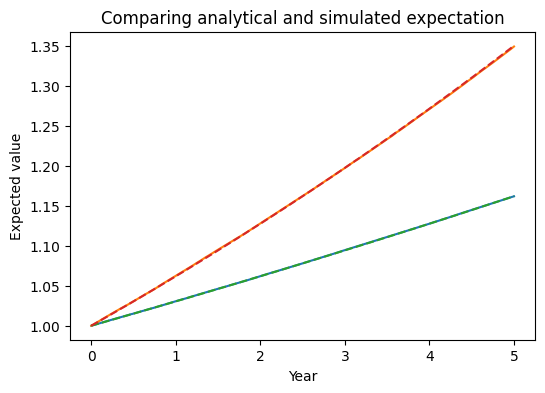

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(time_points, np.mean(risky_asset_prices, axis=0))
plt.plot(time_points, np.exp(time_points[:, None] * mu[None, :]),
         linestyle="--");

ax.set(ylabel="Expected value", xlabel="Year", title="Comparing analytical and simulated expectation"); 

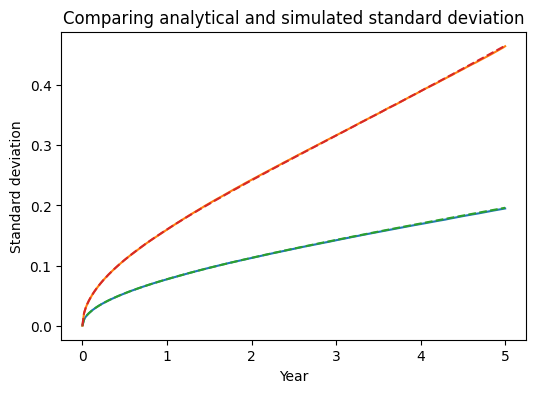

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, np.std(risky_asset_prices, axis=0))

ax.plot(time_points,
         np.sqrt(np.array([np.diag(calculate_covariance_geo(mu, cov_mat, t)[0])
                           for t in time_points])),
         linestyle="--");

ax.set(ylabel="Standard deviation", xlabel="Year", title="Comparing analytical and simulated standard deviation"); 

__Check constant-mix mean and standard deviation__

Compare the analytical mean and standard deviation with their simulated counterparts

In [11]:
"""
Calculate returns of the constant-mix strategy, assuming an equally weighted strategy
"""

w_eq = np.array([0.5, 0.5])

risky_asset_per_ret = (risky_asset_prices[:, 1:, :] - risky_asset_prices[:, :-1]) / risky_asset_prices[:, :-1, :]

const_mix_per_ret = risky_asset_per_ret @ w_eq
const_mix_mv = np.c_[np.ones(num_sim), np.cumprod(1 + const_mix_per_ret, axis=1)]

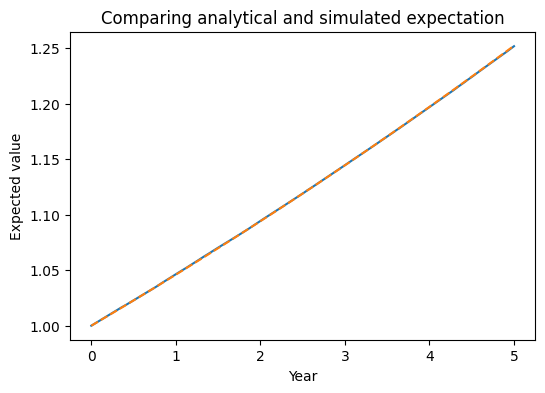

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, np.mean(const_mix_mv, axis=0))
ax.plot(time_points, np.exp(time_points * (w_eq @ mu)), linestyle="--");

ax.set(ylabel="Expected value", xlabel="Year", title="Comparing analytical and simulated expectation"); 

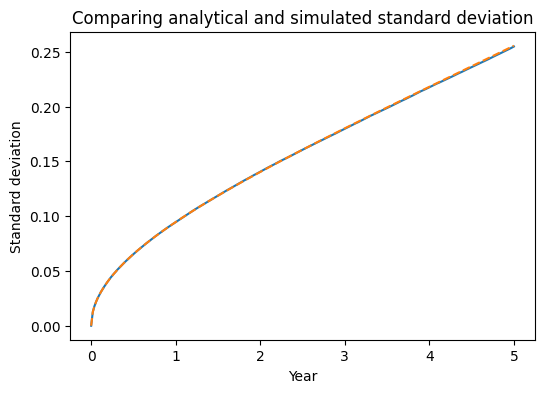

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time_points, np.std(const_mix_mv, axis=0))
ax.plot(time_points, np.sqrt(np.array([calculate_variance_constant_mix(w_eq, mu, cov_mat, t) for t in time_points])),
         linestyle="--");

ax.set(ylabel="Standard deviation", xlabel="Year", title="Comparing analytical and simulated standard deviation"); 

__Fan chart for comparing percentiles of constant-mix portfolio__

In [14]:
# calculate simulated percentiles
percentiles = np.percentile(const_mix_mv, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)
# calculating analytical percentiles
true_percentiles = np.array([calculate_percentile_constant_mix(w_eq, mu, cov_mat, t,
                             q=[0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.75 , 0.9  , 0.95 , 0.975]) for t in time_points])


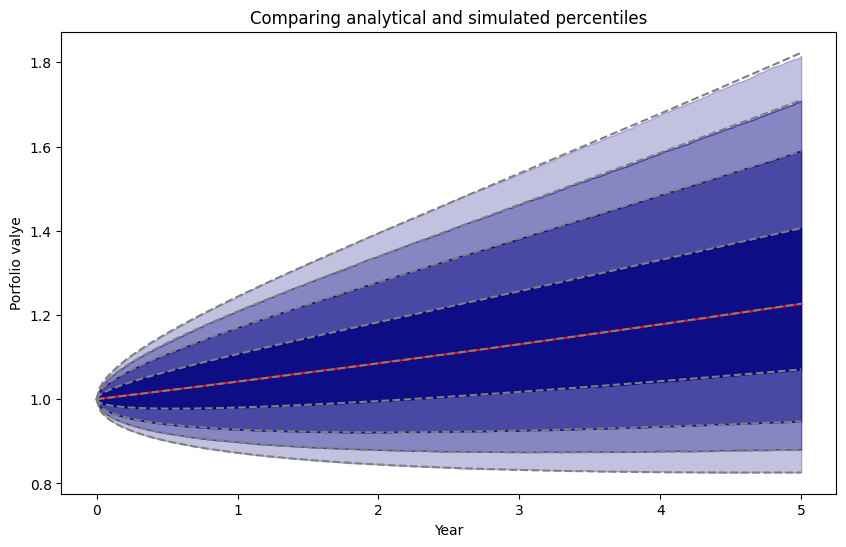

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points, percentiles, ax=ax, color="navy")
ax.plot(time_points, true_percentiles, color="gray", linestyle="--");

ax.set(ylabel="Porfolio valye", xlabel="Year", title="Comparing analytical and simulated percentiles"); 

### Optimal buy-and-hold portfolios using minimum-variance optimization



Buy-and-hold minimum variance problem reads

$$
\mathbf{h}^* = \arg \min_{\mathbf{h}} \mathbf{h}^\top \text{Cov}[\mathbf{V}_T] \mathbf{h} 
$$

subject to 

$$
\mathbf{h}^\top \mathbf{1} = 1 
$$

and 

$$
\mathbf{h} \geq 0
$$



In [16]:
def calculate_min_var_buy_and_hold(mu, cov_mat, horizon, w_init=None):
    
    if w_init is None: 
        w_init = np.ones(len(mu)) / len(mu)
    
    cov_mat_v_at_horizon = calculate_covariance_geo(mu, cov_mat, horizon)
    
    budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1.0}
    #mean_constraint = {'type': 'ineq', 'fun': lambda w: (np.exp(mu * t) - 1) @ w - target_mean}
    res = optimize.minimize(lambda w: w @ cov_mat_v_at_horizon @ w,
                   x0=w_init,
                   method='SLSQP',
                   constraints=[budget_constraint], #budget_constraint, 
                   options={'disp': True,
                            'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1.5e-7},
                   bounds=[(0.0, 1.0)] * len(w_init))
    
    return res['x']

In [17]:
horizons = np.arange(0.25, 10.25, 0.25)

min_var_buy_and_hold_weights = np.array([calculate_min_var_buy_and_hold(mu, cov_mat, h, w_init=None) for h in horizons])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0013090225703229611
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002665386368102036
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0040701942940524
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005524570820370012
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00702966244026263
            Iterations: 6
            Function eval

### Optimal constant-mix portfolio using minimum-variance optimization

$$
\mathbf{w}^* = \arg \min_{\mathbf{w}} \text{Var}[V_{CM, T}] = \arg \min_{\mathbf{w}} [e^{T\mathbf{w}^\top \boldsymbol{\sigma}^2 \mathbf{w}} - 1]e^{2\mathbf{w}^\top \boldsymbol{\mu}T}
$$

subject to 

$$
\mathbf{w}^\top \mathbf{1} = 1 
$$

and 

$$
\mathbf{w} \geq 0
$$

In [18]:
def calculate_min_var_constant_mix(mu, cov_mat, horizon, w_init=None):
    
    if w_init is None: 
        w_init = np.ones(len(mu)) / len(mu)
    
    budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1.0} 
    #mean_constraint = {'type': 'ineq', 'fun': lambda w: calculate_expectation_constant_mix(w, mu, t) - 1 - target_mean}
    res = optimize.minimize(lambda w: calculate_variance_constant_mix(w, mu, cov_mat, horizon),
             x0=w_init,
             method='SLSQP',
             constraints=[budget_constraint], #budget_constraint, 
             options={'disp': True,
                      'ftol': 1e-16,
                      'maxiter': 5000, 
                      'eps': 1.5e-7},
             bounds=[(0.0, 1.0)] * len(w_init))
    
    return res['x']

In [19]:
min_var_constant_mix_weights = np.array([calculate_min_var_constant_mix(mu, cov_mat, h, w_init=None) for h in horizons])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0013087702741828272
            Iterations: 8
            Function evaluations: 25
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0026644146635660918
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.004068093580017479
            Iterations: 79
            Function evaluations: 796
            Gradient evaluations: 79
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005520990674166472
            Iterations: 34
            Function evaluations: 279
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00702431321335325
            Iterations: 8
            Func

### Compare weights from constant mix and buy and hold

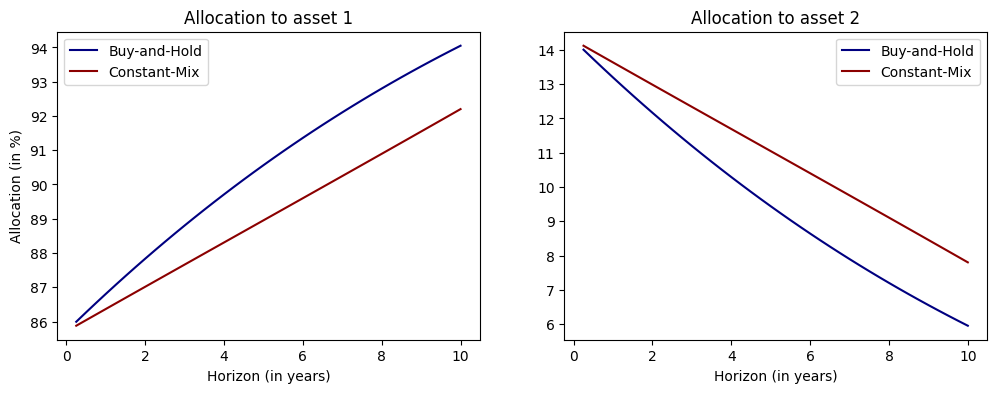

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].plot(horizons, min_var_buy_and_hold_weights[:, 0] * 100, color="navy", label="Buy-and-Hold")
ax[0].plot(horizons, min_var_constant_mix_weights[:, 0] * 100, color="darkred", label="Constant-Mix")

ax[0].set_xlabel("Horizon (in years)")
ax[0].set_ylabel("Allocation (in %)")
ax[0].set_title("Allocation to asset 1")

ax[0].legend();

ax[1].plot(horizons, min_var_buy_and_hold_weights[:, 1] * 100, color="navy", label="Buy-and-Hold")
ax[1].plot(horizons, min_var_constant_mix_weights[:, 1] * 100, color="darkred", label="Constant-Mix")

ax[1].set_xlabel("Horizon (in years)")
#ax[1].set_ylabel("Allocation (in %)")
ax[1].set_title("Allocation to asset 2");

ax[1].legend();

### Comparing mean-variance allocations 

For the mean-variance allocation, we simply need to add the constraints: 

__Buy and Hold__

$$
\mathbf{h}^\top \text{E}[\mathbf{V}_T] = e^{0.05 T}
$$

__Constant-Mix__

$$
e^{\mathbf{w}^\top \boldsymbol{\mu} T} = e^{0.05 T}
$$

Thus, clearly $\mathbf{w}^\top \boldsymbol{\mu} = 0.05$ for all horizons in the constant-mix case. You should find the same weights for all horizons in the constant-mix case!

In [21]:
def calculate_mean_var_buy_and_hold(mu, cov_mat, horizon, target_mean, w_init=None):
    
    if w_init is None: 
        w_init = np.ones(len(mu)) / len(mu)
    
    cov_mat_v_at_horizon = calculate_covariance_geo(mu, cov_mat, horizon)
    mean_v_at_horizon = calculate_expectation_geo(mu, horizon)
    
    budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1.0}
    mean_constraint = {'type': 'ineq', 'fun': lambda w: mean_v_at_horizon @ w - target_mean}
    res = optimize.minimize(lambda w: w @ cov_mat_v_at_horizon @ w,
                   x0=w_init,
                   method='SLSQP',
                   constraints=[budget_constraint, mean_constraint], #budget_constraint, 
                   options={'disp': True,
                            'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1.5e-7},
                   bounds=[(0.0, 1.0)] * len(w_init))
    
    return res['x']

In [22]:
def calculate_mean_var_constant_mix(mu, cov_mat, horizon, target_mean, w_init=None):
    
    if w_init is None: 
        w_init = np.ones(len(mu)) / len(mu)
    
    budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1.0} 
    mean_constraint = {'type': 'ineq', 'fun': lambda w: calculate_expectation_constant_mix(w, mu, horizon) - target_mean}
    res = optimize.minimize(lambda w: calculate_variance_constant_mix(w, mu, cov_mat, horizon),
             x0=w_init,
             method='SLSQP',
             constraints=[budget_constraint, mean_constraint], #budget_constraint, 
             options={'disp': True,
                      'ftol': 1e-16,
                      'maxiter': 5000, 
                      'eps': 1.5e-7},
             bounds=[(0.0, 1.0)] * len(w_init))
    
    return res['x']

In [23]:
compound_ret_target = 0.05

mean_var_buy_and_hold_weights = np.array([calculate_mean_var_buy_and_hold(mu, cov_mat, h,
                                                                          np.exp(compound_ret_target * h), w_init=None) 
                                          for h in horizons])
mean_var_constant_mix_weights = np.array([calculate_mean_var_constant_mix(mu, cov_mat, h,
                                                                          np.exp(compound_ret_target * h), w_init=None) 
                                          for h in horizons])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002992535838093605
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.006162791479793279
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.009518720271298919
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.013068593012007487
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01682100985974633
            Iterations: 3
            Function evalu

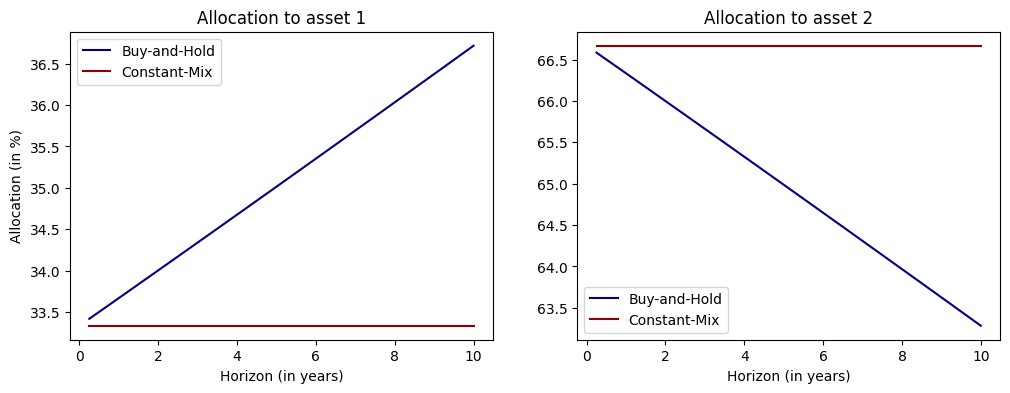

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].plot(horizons, mean_var_buy_and_hold_weights[:, 0] * 100, color="navy", label="Buy-and-Hold")
ax[0].plot(horizons, mean_var_constant_mix_weights[:, 0] * 100, color="darkred", label="Constant-Mix")

ax[0].set_xlabel("Horizon (in years)")
ax[0].set_ylabel("Allocation (in %)")
ax[0].set_title("Allocation to asset 1")

ax[0].legend();

ax[1].plot(horizons, mean_var_buy_and_hold_weights[:, 1] * 100, color="navy", label="Buy-and-Hold")
ax[1].plot(horizons, mean_var_constant_mix_weights[:, 1] * 100, color="darkred", label="Constant-Mix")

ax[1].set_xlabel("Horizon (in years)")
#ax[1].set_ylabel("Allocation (in %)")
ax[1].set_title("Allocation to asset 2");

ax[1].legend();

### Evaluating strategies

In [25]:
"""
Define final MV of constant-mix strategy
"""

risky_asset_per_ret = (risky_asset_prices[:, 1:, :] - risky_asset_prices[:, :-1]) / risky_asset_prices[:, :-1, :]
opt_const_mix_per_ret = risky_asset_per_ret @ mean_var_constant_mix_weights[-1, :]
opt_const_mix_mv = np.c_[np.ones(num_sim), np.cumprod(1 + opt_const_mix_per_ret, axis=1)]

In [26]:
"""
Define final MV of Buy-and-hold strategy
"""

opt_buy_and_hold_mv = risky_asset_prices @ mean_var_buy_and_hold_weights[-1, :]

In [27]:
"""
Combine in dataframe
"""

df_final_values = pd.DataFrame({'CM': opt_const_mix_mv[:, -1], 'BH': opt_buy_and_hold_mv[:, -1]})

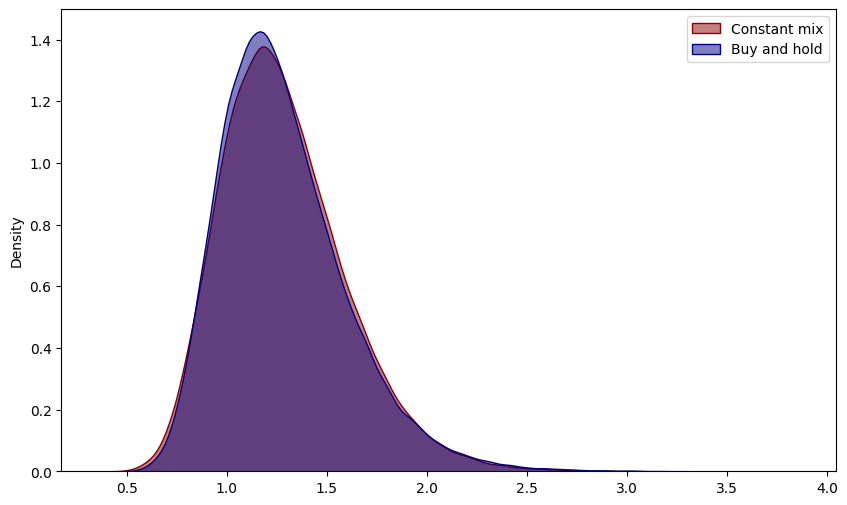

In [28]:
"""
Density plots
"""

fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(opt_const_mix_mv[:, -1], ax=ax, fill=True,
            color="darkred", alpha=0.5, label="Constant mix")
sns.kdeplot(opt_buy_and_hold_mv[:, -1], ax=ax, fill=True,
            color="navy", alpha=0.5, label="Buy and hold")

ax.legend();

In [29]:
"""
Calculate some relevant metrics
"""

calc_cvar = lambda x: rm.calculate_conditional_value_at_risk(np.asarray(x), p=0.05)

df_res = df_final_values.aggregate([mom.calculate_mean,
                                    mom.calculate_std,
                                    mom.calculate_skewness,
                                    mom.calculate_kurtosis,
                                    calc_cvar])

df_res.index = pd.Index(['Mean', 'Standard deviation', 'Skewness', 'Kurtosis', 'CVaR(95%)'])
df_res

,CM,BH
Mean,1.283441,1.280167
Standard deviation,0.313434,0.315996
Skewness,0.744602,0.964013
Kurtosis,0.977853,1.723075
CVaR(95%),0.761403,0.781671


# Problem 2: Portfolio insurance strategies

## Modelling the "market" 

We have assumed that the two risky investment follows a Geometric Brownian motion 

$$
dV_t^1 = V_{1,t} \mu_1 dt + \sigma_1 V_{1,t} dZ_{1,t}
$$

which can equivalently be written as 

$$
d \log V_{1,t} = (\mu_1 - \sigma_1^2 / 2) dt + \sigma_1 dZ_{1,t}
$$

The short rate $r_t$ follows a Vasicek model 

$$
dr_t = \kappa [\theta - r_t] dt + \beta dZ_{2,t} 
$$

It is assumed that $E[dZ_{1,t} dZ_{2,t}] = 0$ (the innovations are uncorrelated). 

### Simulate risky asset prices

In [30]:
"""
Simulate weekly values of the risky asset into the future 
"""
np.random.seed(222)

sigma = 0.15
mu = 0.06

num_sim = 100000
dt = 1.0 / 52.0 
horizon = 5.0 
num_time_steps = int(horizon / dt)
time_points = np.arange(0, num_time_steps + 1, 1) * dt

risky_log_ret = np.random.normal(loc=(mu - 0.5 * sigma**2) * dt,
                                 scale=sigma * np.sqrt(dt),
                                 size=(num_sim, num_time_steps))

risky_mv = np.c_[np.ones(num_sim), np.exp(np.cumsum(risky_log_ret, axis=1))]

### Simulating the Vasicek Model for the short rate

In [31]:
"""
Simulate weekly values of the bank account into the future 
"""

def simulate_vasicek(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000):
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """
    std_rates = np.sqrt(beta**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]

    return short_rates

In [32]:
initial_rate = 0.03
kappa = 1.0
theta = 0.03
beta = 0.02

short_rates = simulate_vasicek(initial_short_rate=initial_rate,
                               kappa=kappa,
                               theta=theta,
                               beta=beta,
                               horizon=horizon, 
                               dt=dt,
                               num_sim=num_sim)

### Development of the bank account

Given the short rate, we can calculate the development of the bank account as 

$$
B_t = B_{t - \Delta t}e^{r_{t-\Delta t} \Delta t}
$$

where $\Delta t$ is the simulation time step

In [33]:
bank_account_mv = np.c_[np.ones(num_sim), np.exp(np.cumsum(short_rates[:, :-1]*dt, axis=1))]

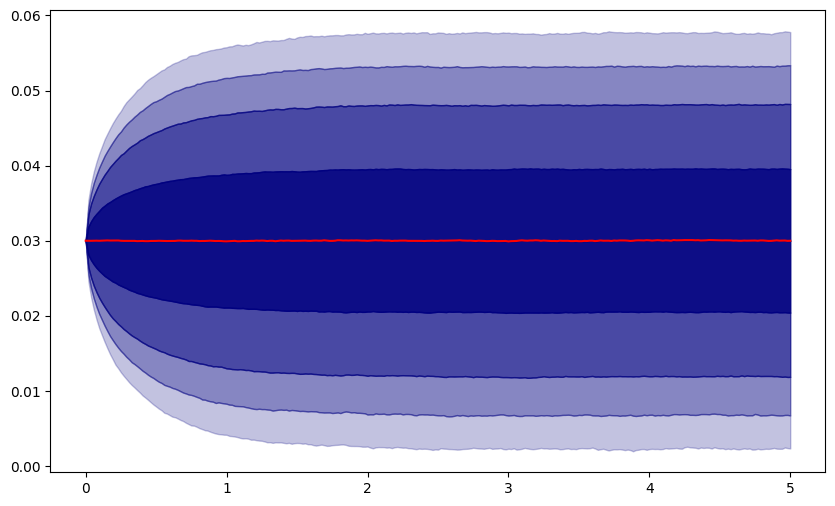

In [34]:
"""
Plot fan chart of short rates
"""
percentiles = np.percentile(short_rates, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

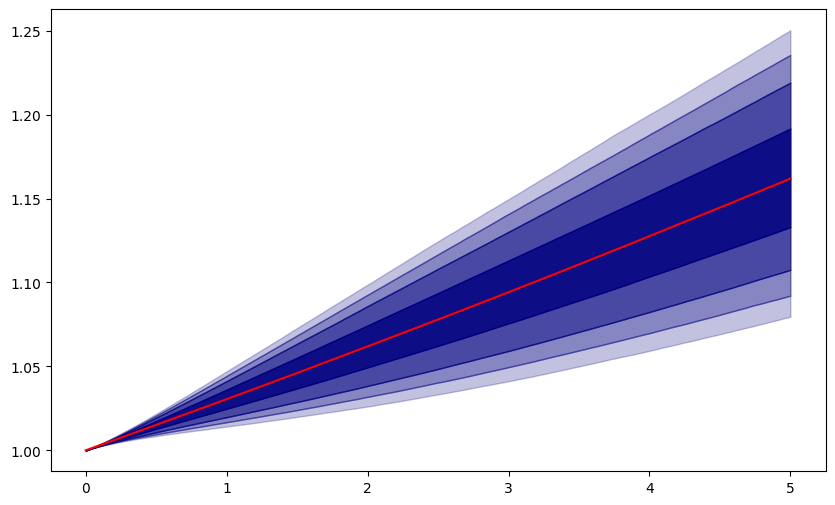

In [35]:
"""
Plot fan chart of bank account
"""

percentiles = np.percentile(bank_account_mv, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

### Optimal buy-and-hold and constant-mix

In [36]:
initial_mv = 1_000_000

# define asset universe
asset_prices =   np.zeros((num_sim, num_time_steps + 1, 2))
asset_prices[:, :, 0] = risky_mv  
asset_prices[:, :, 1] = bank_account_mv

In [37]:
"""
Define function to calculate the utility
"""

def crra_utility(w, gamma=2) :
    
    """
    Function calculating utility. 
    """
    
    return w**(1 - gamma) / (1 - gamma)

def calculate_cm_mv(w: np.ndarray, v: np.ndarray, initial_mv: float):
    
    """
    Function calculating market value of constant-mix strategy. 
    """
    
    asset_per_ret = (v[:, 1:, :] - v[:, :-1]) / v[:, :-1, :]
    strat_per_ret = asset_per_ret @ w
    strat_mv = initial_mv * np.c_[np.ones(num_sim),
                                  np.cumprod(1 + strat_per_ret, axis=1)]
    
    return strat_mv

"""
Define function calculating the expected utility for at number of simulated paths
"""

def bh_crra_utility(h: np.ndarray, v: np.ndarray, gamma: float = 2.0):
    
    strat_mv = v @ h
    
    avg_util = np.average(crra_utility(strat_mv[:, -1], gamma=gamma))
    
    #print(h, -avg_util)
    
    return avg_util

def cm_crra_utility(w: np.ndarray, v: np.ndarray,
                    initial_mv: float, gamma: float = 2.0):
    
    strat_mv = calculate_cm_mv(w, v, initial_mv)
    
    avg_util = np.average(crra_utility(strat_mv[:, -1], gamma=gamma))
    
    #print(w, -avg_util)
    
    return avg_util

### Optimal Buy and Hold portfolio 

#### Option 1: Use scipy.minimize to maximize expected utility directly

The optimization problem reads for the Buy-and-Hold case (let $\mathbf{V}_5$ be the vector consisting of the risky asset and bank account prices at year 5)

$$
\mathbf{h}^* = \arg \max_{\mathbf{h}} \mathbb{E}[U^{CRRA}(\mathbf{h}^\top \mathbf{V}_5)]
$$

subject to 

$$
\mathbf{h}^\top \mathbf{1} = 1 
$$

and 

$$
\mathbf{h} \geq 0
$$

We can approximate $\mathbb{E}[U^{CRRA}(\mathbf{h}^\top \mathbf{V}_5)]$ using a large number of simulations. 

In [38]:
"""
Optimal buy-and-hold allocation
"""

budget_constraint = {'type': 'eq', 'fun': lambda h: h.sum() - initial_mv}

h_init= np.array([5e5, 5e5])
res = optimize.minimize(lambda h: -bh_crra_utility(h, asset_prices, gamma=2) * 1e16,
                   x0=h_init,
                   method='SLSQP',
                   constraints=[budget_constraint],
                   options={'disp': True,
                            #'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1e-12},
                   bounds=[(0.0, 1e6)] * len(h_init)
                       )
    
h_bh_opt = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8193891668.05267
            Iterations: 14
            Function evaluations: 58
            Gradient evaluations: 14


In [39]:
h_bh_opt 

array([668619.40173387, 331380.59826613])

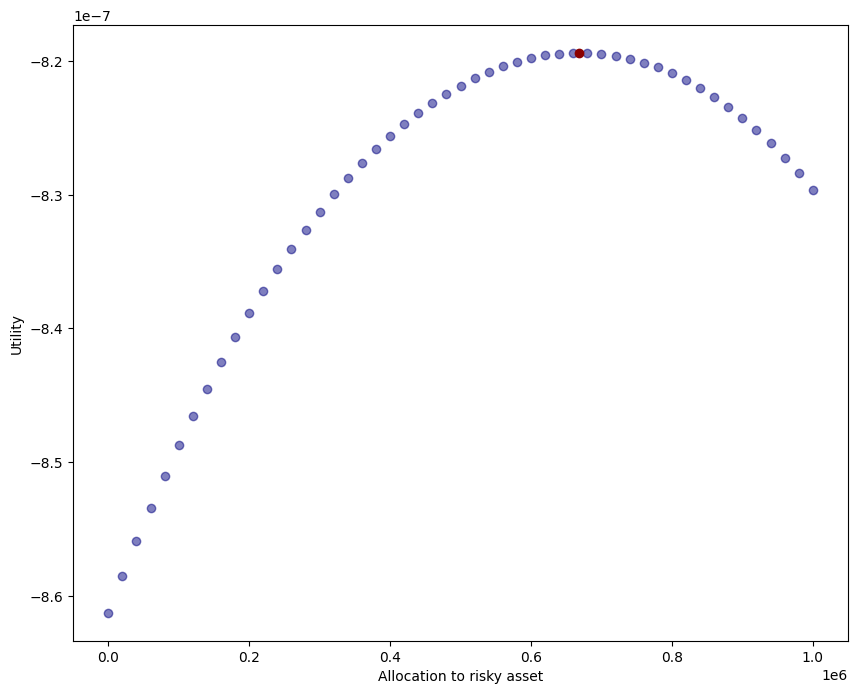

In [40]:
"""
Calculate utility for different buy and hold allocation
"""
bh_diff_h = np.array([[h, 1e6 - h] for h in np.linspace(0, 1e6, 51)])
bh_diff_util = [bh_crra_utility(bh_diff_h[i, :], asset_prices, gamma=2) 
             for i in range(len(bh_diff_h))]

"""
Plot results
"""

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(bh_diff_h[:, 0], bh_diff_util, color="navy", alpha=0.5)
ax.scatter(h_bh_opt[0], bh_crra_utility(h_bh_opt, asset_prices, gamma=2),
           color="darkred", label="Optimal buy-and-hold");

ax.set(xlabel="Allocation to risky asset", ylabel="Utility");

#### Option 2: Grid search

As an alternative grid search can be performed to find the solution or a good starting value!

In [41]:
optimize.brute(lambda x: -bh_crra_utility(np.array([x * initial_mv, (1-x) * initial_mv]), asset_prices, gamma=2),
               ranges=(slice(0.0, 1.0, 0.001),))

array([0.66860801])

#### Option 3: Mean-Variance as an initial step

Find different mean-variance efficient portfolios and select the one with the highest average utility. 

### Optimal constant-mix portfolio

Again, we can use simulation to create a function that approximates the expected utility which we can maximize

In [42]:
"""
Optimal constant mix allocation 
"""

budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

w_init= np.array([0.4, 0.6])
res = optimize.minimize(lambda w: -cm_crra_utility(w, asset_prices, 
                                                   initial_mv,gamma=2)*1e7,
                   x0=w_init,
                   #method='SLSQP',
                   constraints=[budget_constraint],
                   options={'disp': True,
                            #'ftol': 1e-16,
                            'maxiter': 5000,
                            'eps': 1e-12,
                            }, 
                            #'eps': 1.5e-14},
                   bounds=[(0.0, 1.0)] * len(w_init)
                       )
    

w_cm_opt = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.192311487442286
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3


In [43]:
w_cm_opt

array([0.66542396, 0.33457604])

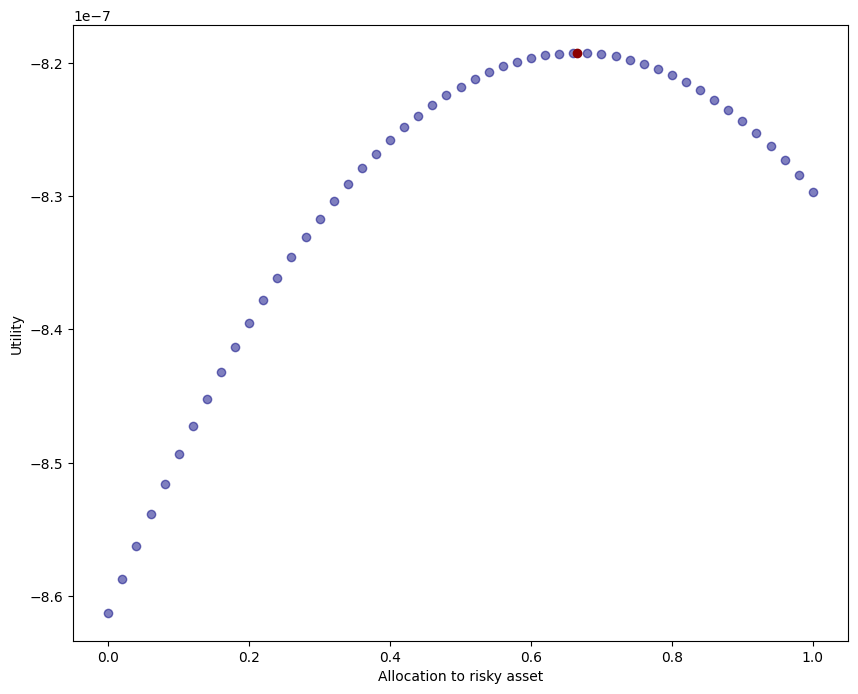

In [44]:
"""
Calculate utility for different buy and hold allocation
"""
cm_diff_w = np.array([[w, 1 - w] for w in np.linspace(0, 1, 51)])
cm_diff_util = [cm_crra_utility(cm_diff_w[i, :], asset_prices, initial_mv,
                                gamma=2) 
             for i in range(len(cm_diff_w))]

"""
Plot results
"""

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(cm_diff_w[:, 0], cm_diff_util, color="navy", alpha=0.5)
ax.scatter(w_cm_opt[0], cm_crra_utility(w_cm_opt, asset_prices, initial_mv,
                                        gamma=2),
           color="darkred", label="Optimal buy-and-hold");

ax.set(xlabel="Allocation to risky asset", ylabel="Utility");

### Evaluating optimal portfolios

In [45]:
opt_bh_mv = asset_prices @ h_bh_opt

In [46]:
asset_per_ret = (asset_prices[:, 1:, :] - asset_prices[:, :-1]) / asset_prices[:, :-1, :]
strat_per_ret = asset_per_ret  @ w_cm_opt
opt_cm_mv = initial_mv * np.c_[np.ones(num_sim), np.cumprod(1 + strat_per_ret, axis=1)]

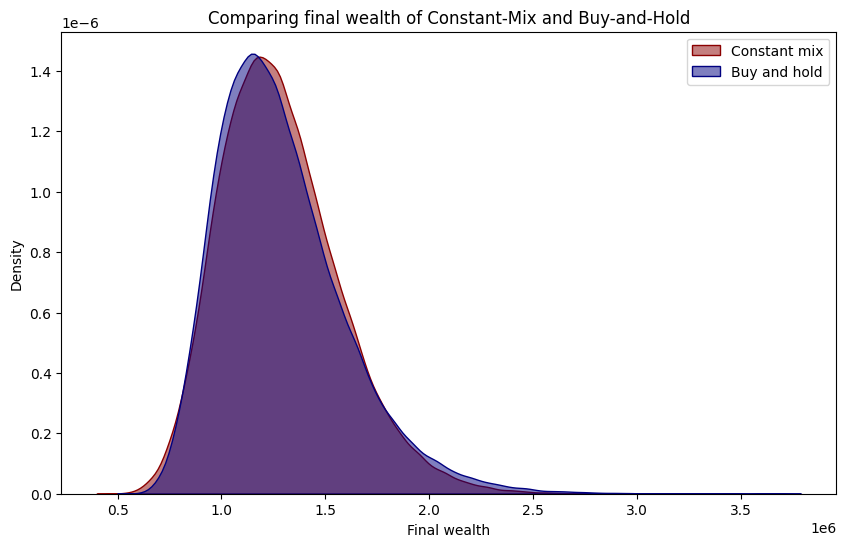

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(opt_cm_mv[:, -1], ax=ax, fill=True,
            color="darkred", alpha=0.5, label="Constant mix")
sns.kdeplot(opt_bh_mv[:, -1], ax=ax, fill=True,
            color="navy", alpha=0.5, label="Buy and hold")

ax.set(xlabel="Final wealth", title="Comparing final wealth of Constant-Mix and Buy-and-Hold")

ax.legend();
    

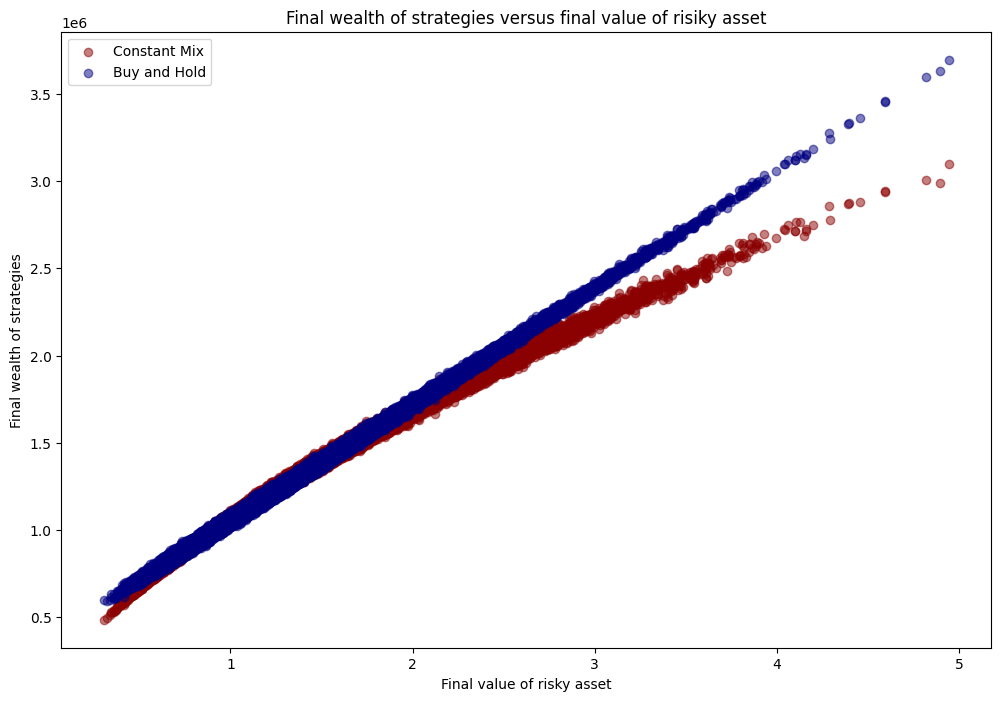

In [48]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(asset_prices[:, -1, 0], opt_cm_mv[:, -1], color="darkred", alpha=0.5, label="Constant Mix")
ax.scatter(asset_prices[:, -1, 0], opt_bh_mv[:, -1], color="navy", alpha=0.5, label='Buy and Hold')

ax.set(xlabel="Final value of risky asset", ylabel="Final wealth of strategies",
       title="Final wealth of strategies versus final value of risiky asset")

ax.legend();

In [49]:
df_final_wealth = pd.DataFrame({'CM': opt_cm_mv[:, -1], 'BH': opt_bh_mv[:, -1],
                                'CM Utility': crra_utility(opt_cm_mv[:, -1], 2), 
                                'BH Utility': crra_utility(opt_bh_mv[:, -1], 2)})

In [50]:
df_res = df_final_wealth.aggregate([mom.calculate_mean,
                                    mom.calculate_std,
                                    mom.calculate_skewness,
                                    mom.calculate_kurtosis,
                                    calc_cvar])

df_res.index = pd.Index(['Mean', 'Standard deviation', 'Skewness', 'Kurtosis', 'CVaR(95%)'])

In [51]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(df_res[['CM', 'BH']])

,CM,BH
Mean,"1,283,010.68","1,286,774.86"
Standard deviation,"289,741.77","310,233.38"
Skewness,0.67,1.04
Kurtosis,0.74,1.83
CVaR(95%),"792,321.75","814,202.49"


In [52]:
with pd.option_context('display.float_format', '{:.10f}'.format):
    display(df_res[['CM Utility', 'BH Utility']])

,CM Utility,BH Utility
Mean,-0.0000008192,-0.0000008194
Standard deviation,0.0000001852,0.0000001845
Skewness,-0.6883549137,-0.3508991563
Kurtosis,0.8439557316,0.0370003473
CVaR(95%),-0.0000012710,-0.0000012333


### Constant Proportional Portfolio Insurance

In [53]:
def calculate_cppi_strategy(multiplier: float,
                            floor: float,
                            v: np.ndarray,
                            initial_market_value: float, 
                            leverage_constraint: float=1.0,
                            scale_floor: bool=True,
                            scale: np.ndarray = None): 
    
    if scale is None: 
        scale = v[:, :, 1]
    else: 
        scale = scale
    
    if scale_floor: 
        floors = floor * scale
    else: 
        floors = floor * np.ones_like(v[:, :, 1])
        
    num_time_points = v[:, :, 1].shape[1]
    
    # holding risky and risk free
    h_risky_cppi = np.zeros_like(v[:, :, 1])
    h_risk_free_cppi = np.zeros_like(v[:, :, 1])

    # mv of strategy
    cppi_strat_mv = np.zeros_like(v[:, :, 1])
    cppi_strat_mv[:, 0] = initial_market_value
    
    # cushion
    cush_cppi = np.zeros_like(v[:, :, 1])
    
    for i in range(num_time_points - 1): 
        
        # define cushin and market value allocated to the risky asset
        cush_cppi[:, i] = np.maximum(0, cppi_strat_mv[:, i] - floors[:, i])
        mv_in_risky = np.minimum(multiplier * cush_cppi[:, i], leverage_constraint * cppi_strat_mv[:, i])

        # determine the allocation in terms of holdings for both the risky and risk-free asset
        h_risky_cppi[:, i] = mv_in_risky / v[:, i, 0] 
        h_risk_free_cppi[:, i] = (cppi_strat_mv[:, i] - h_risky_cppi[:, i] * v[:, i, 0]) / v[:, i, 1]
        
        # calculate the value of the strategy
        cppi_strat_mv[:, i + 1] = (cppi_strat_mv[:, i] + h_risky_cppi[:, i]*(v[:, i + 1, 0] - v[:, i, 0]) + 
                                   h_risk_free_cppi[:, i]*(v[:, i + 1, 1] - v[:, i, 1]))
    

    cush_cppi[:, -1] = np.maximum(0, cppi_strat_mv[:, -1] - floors[:, -1])  
    h_risky_cppi[:, -1] = np.minimum(multiplier * cush_cppi[:, -1],  leverage_constraint * cppi_strat_mv[:, -1]) / v[:, -1, 0]
    h_risk_free_cppi[:, -1] = (cppi_strat_mv[:, -1] - h_risky_cppi[:, -1] * v[:, -1, 0]) / v[:, -1, 1]
    
    return h_risky_cppi, h_risk_free_cppi, cppi_strat_mv, cush_cppi
    

In [54]:
h_risky, h_risk_free_cppi, cppi_strat_mv, cush_cppi = calculate_cppi_strategy(multiplier=2.5,
                                                                              floor=7e5,
                                                                              v=asset_prices,
                                                                              initial_market_value=1e6,
                                                                              leverage_constraint=1.0,
                                                                              scale_floor=True,
                                                                              scale=asset_prices[:, :, 1])

In [55]:
print(opt_cm_mv[:, -1].mean())
print(opt_bh_mv[:, -1].mean())
print(cppi_strat_mv[:, -1].mean())

1283010.6824379854
1286774.8632575641
1304872.112432243


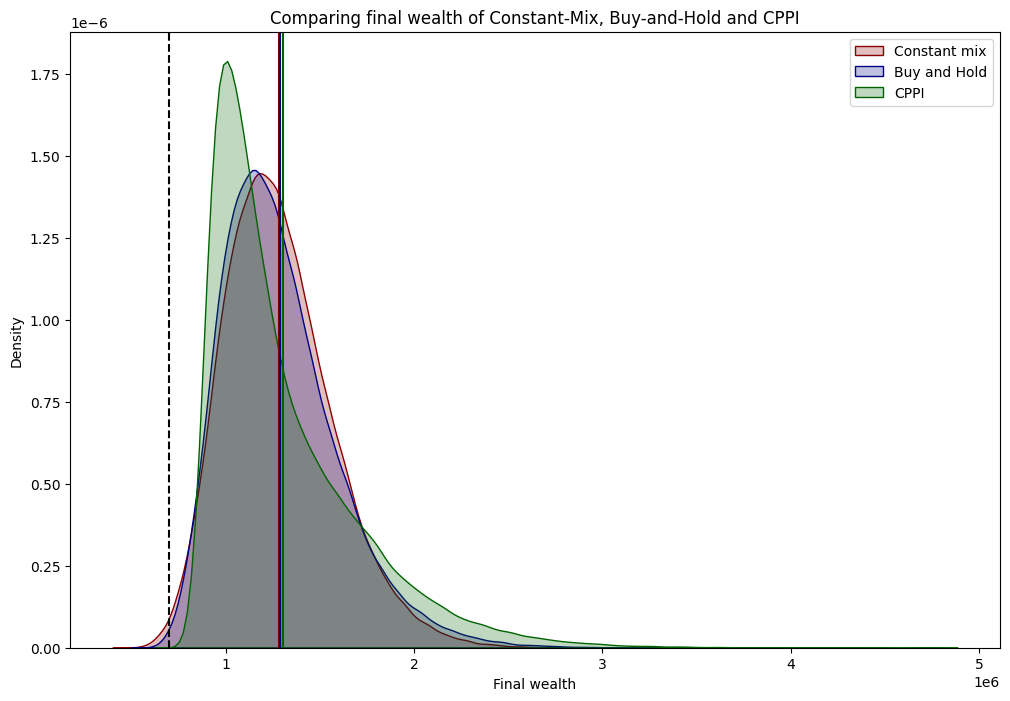

In [56]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(opt_cm_mv[:, -1], color="darkred", alpha=0.25, label="Constant mix", fill=True)
sns.kdeplot(opt_bh_mv[:, -1], color="navy", alpha=0.25, label='Buy and Hold', fill=True)
sns.kdeplot(cppi_strat_mv[:, -1], color="darkgreen", alpha=0.25, label="CPPI", fill=True)

ax.axvline(x=opt_cm_mv[:, -1].mean(), color="darkred")
ax.axvline(x=opt_bh_mv[:, -1].mean(), color="navy")
ax.axvline(x=cppi_strat_mv[:, -1].mean(), color="darkgreen")

ax.set(xlabel="Final wealth", title="Comparing final wealth of Constant-Mix, Buy-and-Hold and CPPI")

ax.axvline(x=7e5, color="black", linestyle='--')

ax.legend();

In [57]:
"""
Plot pay off profile
"""
if False: 
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.histplot(opt_cm_mv[:, -1], color="darkred", alpha=0.25, label="Constant mix", fill=True, bins=50)
    sns.histplot(opt_bh_mv[:, -1], color="navy", alpha=0.25, label='Buy and Hold', fill=True, bins=50)
    sns.histplot(cppi_strat_mv[:, -1], color="darkgreen", alpha=0.25, label="CPPI", fill=True, bins=50)

    ax.axvline(x=opt_cm_mv[:, -1].mean(), color="darkred")
    ax.axvline(x=opt_bh_mv[:, -1].mean(), color="navy")
    ax.axvline(x=cppi_strat_mv[:, -1].mean(), color="darkgreen")


    ax.axvline(x=7e5, color="black", linestyle='--')

    ax.legend();

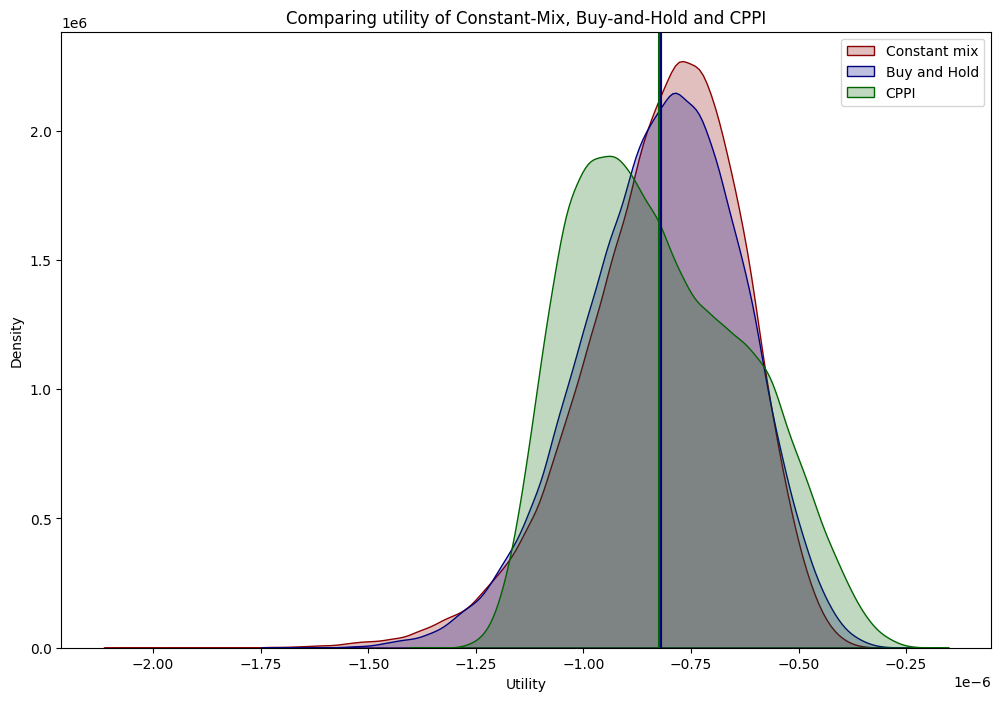

In [58]:
"""
Plot utility distribution - kernel density
"""

crra_gamma = 2

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(crra_utility(opt_cm_mv[:, -1], gamma=crra_gamma), color="darkred", alpha=0.25, label="Constant mix", fill=True)
sns.kdeplot(crra_utility(opt_bh_mv[:, -1], gamma=crra_gamma), color="navy", alpha=0.25, label='Buy and Hold', fill=True)
sns.kdeplot(crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma), color="darkgreen", alpha=0.25, label="CPPI", fill=True)

ax.axvline(x=crra_utility(opt_cm_mv[:, -1], gamma=crra_gamma).mean(), color="darkred")
ax.axvline(x=crra_utility(opt_bh_mv[:, -1], gamma=crra_gamma).mean(), color="navy")
ax.axvline(x=crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma).mean(), color="darkgreen")

ax.set(xlabel="Utility", title="Comparing utility of Constant-Mix, Buy-and-Hold and CPPI")

ax.legend();

In [59]:
"""
Plot utility distribution - histogram
"""

if False: 
    crra_gamma = 2

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.histplot(crra_utility(opt_cm_mv[:, -1], gamma=crra_gamma), color="darkred", alpha=0.25, label="Constant mix",
                 fill=True, bins=50)
    sns.histplot(crra_utility(opt_bh_mv[:, -1], gamma=crra_gamma), color="navy", alpha=0.25, label='Buy and Hold',
                 fill=True, bins=50)
    sns.histplot(crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma), color="darkgreen", alpha=0.25, label="CPPI",
                 fill=True, bins=50)

    ax.axvline(x=crra_utility(opt_cm_mv[:, -1], gamma=crra_gamma).mean(), color="darkred")
    ax.axvline(x=crra_utility(opt_bh_mv[:, -1], gamma=crra_gamma).mean(), color="navy")
    ax.axvline(x=crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma).mean(), color="darkgreen")

    ax.legend();

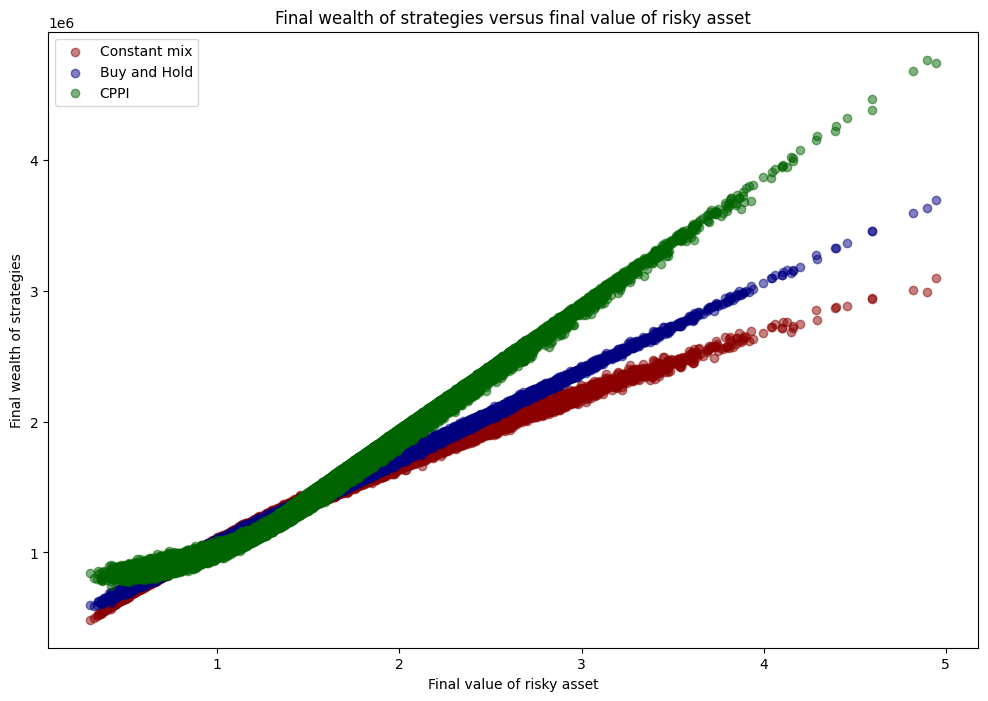

In [60]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(asset_prices[:, -1, 0], opt_cm_mv[:, -1], color="darkred", alpha=0.5, label="Constant mix")
ax.scatter(asset_prices[:, -1, 0], opt_bh_mv[:, -1], color="navy", alpha=0.5, label='Buy and Hold')
ax.scatter(asset_prices[:, -1, 0], cppi_strat_mv[:, -1], color="darkgreen", alpha=0.5, label="CPPI")

ax.set(xlabel="Final value of risky asset", ylabel="Final wealth of strategies",
       title="Final wealth of strategies versus final value of risky asset")


ax.legend();

### Example 

In [61]:
opt_bh_risk_free = asset_prices @ np.array([0, 1])
opt_bh_risky = asset_prices @ np.array([1, 0])
opt_bh_equal = asset_prices @ np.array([0.68, 0.32])

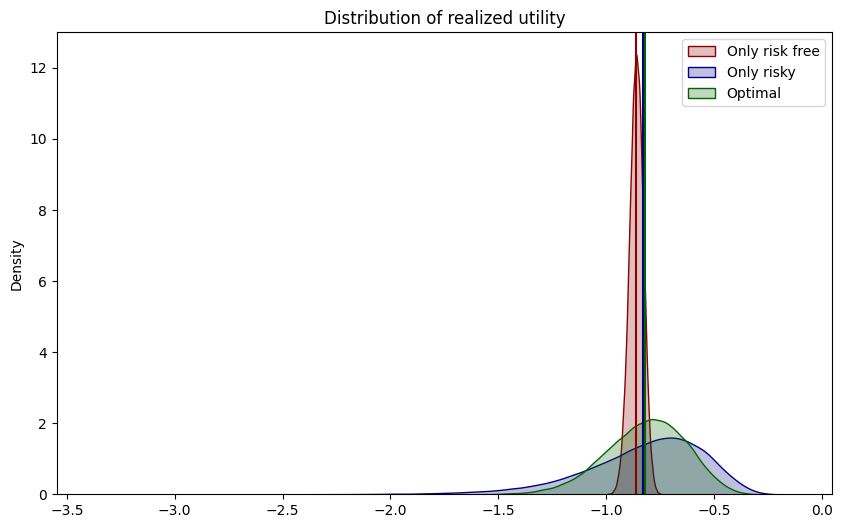

In [62]:
crra_gamma = 2

fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(crra_utility(opt_bh_risk_free[:, -1], gamma=crra_gamma), color="darkred", alpha=0.25, label="Only risk free", fill=True)
sns.kdeplot(crra_utility(opt_bh_risky[:, -1], gamma=crra_gamma), color="navy", alpha=0.25, label='Only risky', fill=True)
sns.kdeplot(crra_utility(opt_bh_equal[:, -1], gamma=crra_gamma), color="darkgreen", alpha=0.25, label="Optimal", fill=True)

ax.axvline(x=crra_utility(opt_bh_risk_free[:, -1], gamma=crra_gamma).mean(), color="darkred")
ax.axvline(x=crra_utility(opt_bh_risky[:, -1], gamma=crra_gamma).mean(), color="navy")
ax.axvline(x=crra_utility(opt_bh_equal[:, -1], gamma=crra_gamma).mean(), color="darkgreen")

ax.set_title("Distribution of realized utility")

ax.legend();

### Buy-and-Hold and Constant-Mix with minimum wealth level

One possibility is to apply a constraint using a numerical optimizer and simulated paths (see below). The allocations will then depend on "worst" simulated path. 

Alternative, one could apply arguments such: 

* For the buy-and-hold case, we need to allocate at least $c=700000$ to the "risk-free" asset. This will ensure that we at least have $c V_{2,5}$ at the end of the investment horizon. 
* For constant-mix case, we need to allocate everything to the risk free assets since we are continuously buying the assets who is decreasing in value. 

In [63]:
asset_prices[:, -1, 0].min()

0.30326860620247054

In [64]:
asset_prices[:, -1, 1].min()

0.987396115245518

In [65]:
asset_prices[:, -1, 1].mean() * 700_000

813897.4916074987

In [66]:
"""
Optimal buy-and-hold allocation
"""

budget_constraint = {'type': 'eq', 'fun': lambda h: h.sum() - initial_mv}
# min_wealth = {'type': 'ineq', 'fun': lambda h: h @ np.array([0, 1]) - 7e5}
min_wealth = {'type': 'ineq', 'fun': lambda h: (asset_prices[:, -1, :] @ h - 
                                                7e5 * asset_prices[:, -1, 1]).min() }


h_init= np.array([5e5, 5e5])
res = optimize.minimize(lambda h: -bh_crra_utility(h, asset_prices, gamma=2) * 1e6,
                   x0=h_init,
                   method='SLSQP',
                   constraints=[budget_constraint, min_wealth],
                   options={'disp': True,
                            #'ftol': 1e-16,
                            'maxiter': 5000, 
                            'eps': 1e-12},
                   bounds=[(0.0, 1e6)] * len(h_init))
    
h_bh_min_wealth_opt = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8255274695137218
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2


In [67]:
h_bh_min_wealth_opt

array([402415.33152296, 597584.66847704])

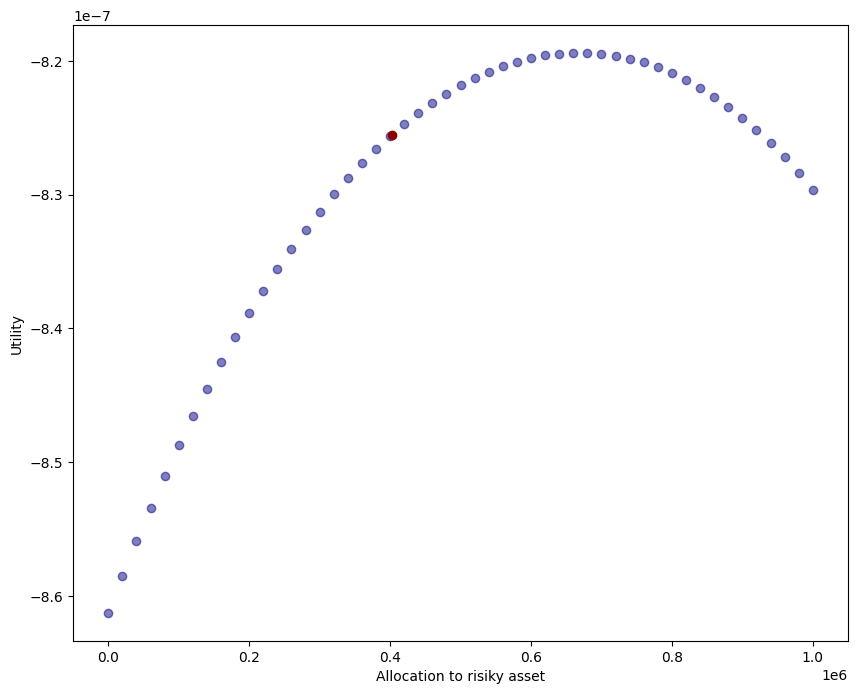

In [68]:
"""
Calculate utility for different buy and hold allocation
"""
bh_diff_h = np.array([[h, 1e6 - h] for h in np.linspace(0, 1e6, 51)])
bh_diff_util = [bh_crra_utility(bh_diff_h[i, :], asset_prices, gamma=2) 
             for i in range(len(bh_diff_h))]

"""
Plot results
"""

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(bh_diff_h[:, 0], bh_diff_util, color="navy", alpha=0.5)
ax.scatter(h_bh_min_wealth_opt[0], bh_crra_utility(h_bh_min_wealth_opt, asset_prices, gamma=2),
           color="darkred", label="Optimal buy-and-hold");

ax.set(xlabel="Allocation to risiky asset", ylabel="Utility");

In [69]:
"""
Optimal constant mix allocation 
"""

budget_constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
min_wealth = {'type': 'ineq', 'fun': lambda w: w @ np.array([0.0, 1.0]) - 0.7}
min_wealth = {'type': 'ineq', 'fun': lambda w: (calculate_cm_mv(w, asset_prices, initial_mv=initial_mv)[:, -1] - 
                                                7e5 * asset_prices[:, -1, 1]).min() }

w_init= np.array([0.4, 0.6])
res = optimize.minimize(lambda w: -cm_crra_utility(w, asset_prices, 
                                                   initial_mv,gamma=2)*1e7,
                   x0=w_init,
                   #method='SLSQP',
                   constraints=[budget_constraint, min_wealth],
                   options={'disp': True,
                            #'ftol': 1e-16,
                            'maxiter': 5000,
                            'eps': 1e-12,
                            }, 
                            #'eps': 1.5e-14},
                   bounds=[(0.0, 1.0)] * len(w_init)
                       )
    

w_cm_min_wealth_opt = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.339216291668718
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


In [70]:
w_cm_min_wealth_opt

array([0.26882258, 0.73117742])

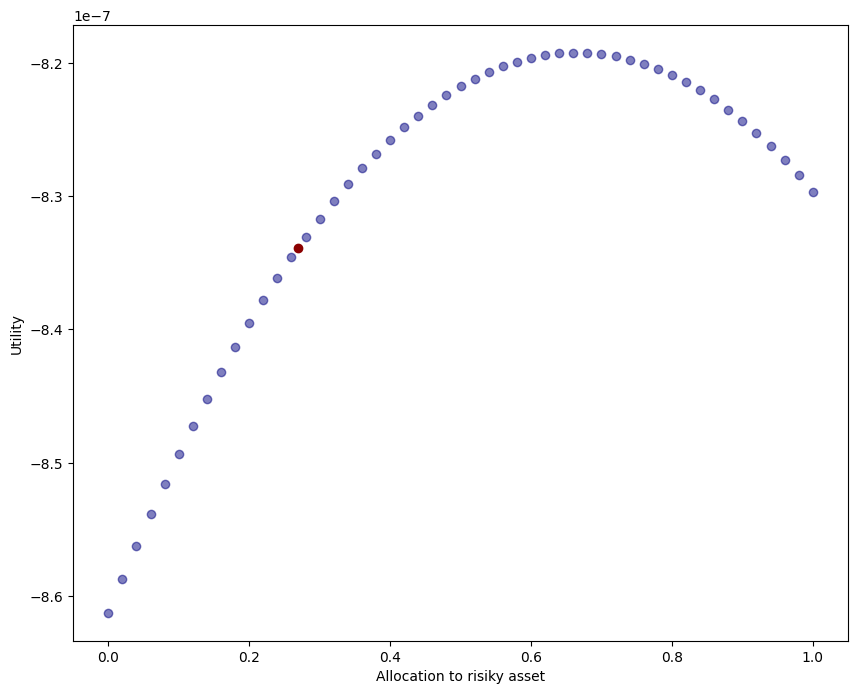

In [71]:
"""
Calculate utility for different buy and hold allocation
"""
cm_diff_w = np.array([[w, 1 - w] for w in np.linspace(0, 1, 51)])
cm_diff_util = [cm_crra_utility(cm_diff_w[i, :], asset_prices, initial_mv,
                                gamma=2) 
             for i in range(len(cm_diff_w))]

"""
Plot results
"""

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(cm_diff_w[:, 0], cm_diff_util, color="navy", alpha=0.5)
ax.scatter(w_cm_min_wealth_opt[0], cm_crra_utility(w_cm_min_wealth_opt, asset_prices, initial_mv,
                                        gamma=2),
           color="darkred", label="Optimal buy-and-hold");

ax.set(xlabel="Allocation to risiky asset", ylabel="Utility");

In [72]:
opt_bh_min_wealth_mv = asset_prices @ h_bh_min_wealth_opt

In [73]:
opt_cm_min_wealth_mv = calculate_cm_mv(w_cm_min_wealth_opt, asset_prices, initial_mv=initial_mv)

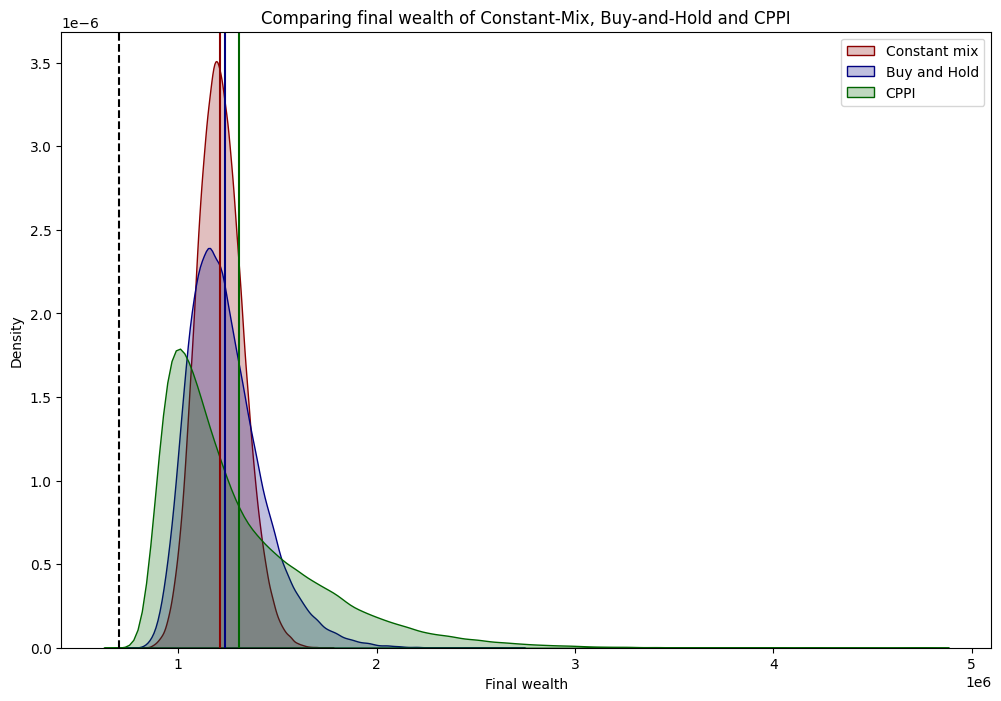

In [74]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(opt_cm_min_wealth_mv[:, -1], color="darkred", alpha=0.25, label="Constant mix", fill=True)
sns.kdeplot(opt_bh_min_wealth_mv[:, -1], color="navy", alpha=0.25, label='Buy and Hold', fill=True)
sns.kdeplot(cppi_strat_mv[:, -1], color="darkgreen", alpha=0.25, label="CPPI", fill=True)

ax.axvline(x=opt_cm_min_wealth_mv[:, -1].mean(), color="darkred")
ax.axvline(x=opt_bh_min_wealth_mv[:, -1].mean(), color="navy")
ax.axvline(x=cppi_strat_mv[:, -1].mean(), color="darkgreen")

ax.set(xlabel="Final wealth", title="Comparing final wealth of Constant-Mix, Buy-and-Hold and CPPI")

ax.axvline(x=7e5, color="black", linestyle='--')


ax.legend();

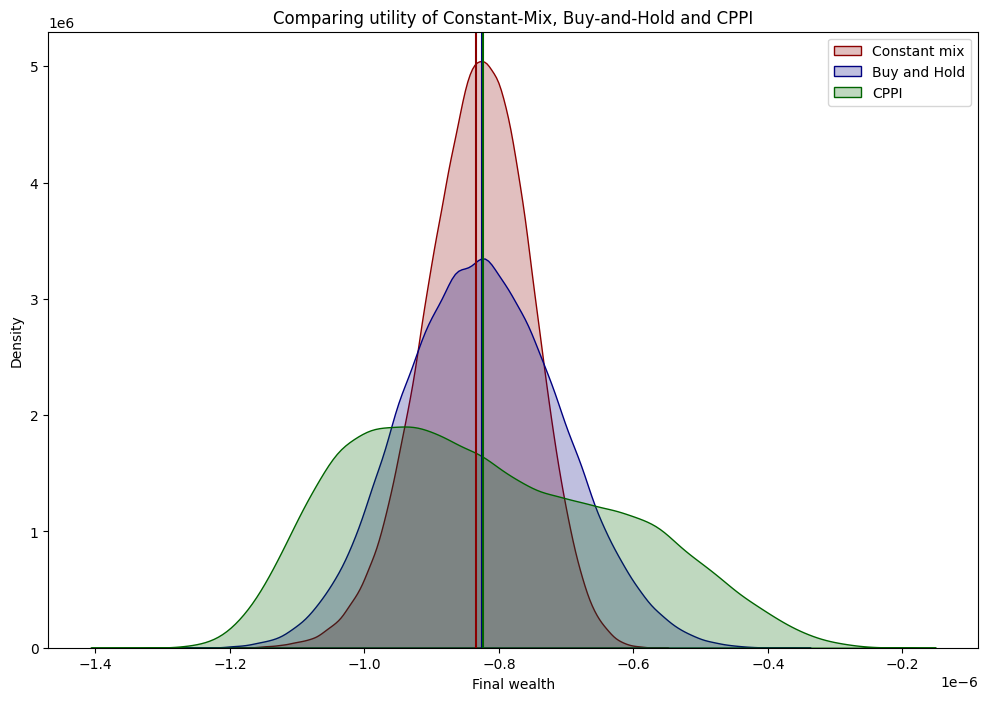

In [75]:
"""
Plot pay off profile
"""

crra_gamma = 2

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(crra_utility(opt_cm_min_wealth_mv[:, -1], gamma=crra_gamma), color="darkred", alpha=0.25, label="Constant mix", fill=True)
sns.kdeplot(crra_utility(opt_bh_min_wealth_mv[:, -1], gamma=crra_gamma), color="navy", alpha=0.25, label='Buy and Hold', fill=True)
sns.kdeplot(crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma), color="darkgreen", alpha=0.25, label="CPPI", fill=True)

ax.axvline(x=crra_utility(opt_cm_min_wealth_mv[:, -1], gamma=crra_gamma).mean(), color="darkred")
ax.axvline(x=crra_utility(opt_bh_min_wealth_mv[:, -1], gamma=crra_gamma).mean(), color="navy")
ax.axvline(x=crra_utility(cppi_strat_mv[:, -1], gamma=crra_gamma).mean(), color="darkgreen")

ax.set(xlabel="Final wealth", title="Comparing utility of Constant-Mix, Buy-and-Hold and CPPI")

ax.legend();

### Change risk free to zero coupon bond

In [76]:
from typing import Union 

def calculate_zero_coupon_yield(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float): 
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return (a + b * initial_short_rate) / time_to_maturity

def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate)

In [77]:
rp = -0.2

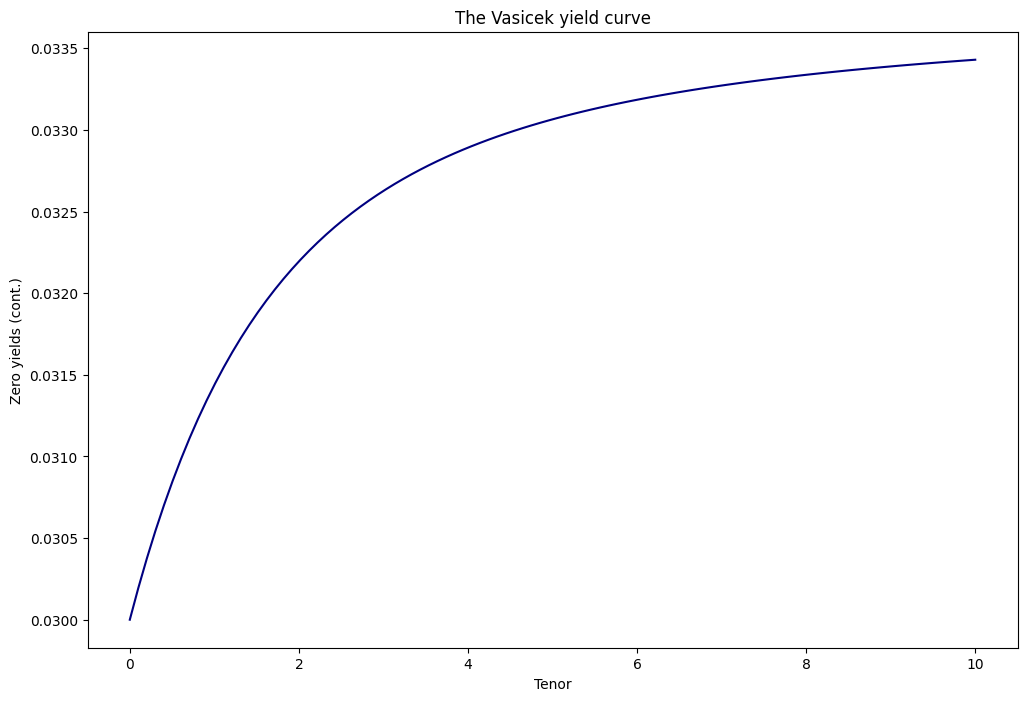

In [78]:
plot_tenors = np.linspace(0.0001, 10.0, 100)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(plot_tenors, calculate_zero_coupon_yield(plot_tenors, initial_rate, kappa, theta, beta, rp), color="navy")
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (cont.)');
ax.set_title("The Vasicek yield curve");

In [79]:
zcb_mv = np.zeros((num_sim, num_time_steps + 1))

for i, t in enumerate(time_points):
    zcb_mv[:, i] = calculate_zero_coupon_price(5.0 - t, short_rates[:, i], kappa, theta, beta, rp)

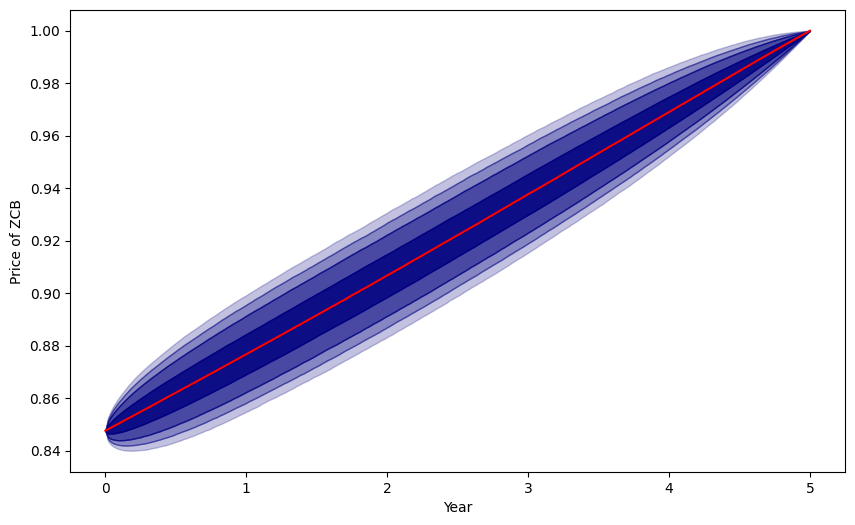

In [80]:
"""
Plot fan chart of bank account
"""

percentiles = np.percentile(zcb_mv, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set(xlabel="Year", ylabel="Price of ZCB");

### CPPI with zero-coupon bond

In [81]:
asset_prices_w_zcb = asset_prices.copy()
asset_prices_w_zcb[:, :, 1] = zcb_mv / zcb_mv[0, 0]

In [82]:
zcb_mv[0, 0]

0.8476188096722358

In [83]:
asset_prices_w_zcb[:,-1, :]

array([[1.58941095, 1.17977561],
       [0.96283121, 1.17977561],
       [1.78217335, 1.17977561],
       ...,
       [0.97262461, 1.17977561],
       [1.59611416, 1.17977561],
       [0.96259857, 1.17977561]])

In [84]:
1 / zcb_mv[0, 0]

1.17977561208993

In [85]:
h_risky_w_zcb, h_risk_free_w_zcb, cppi_strat_mv_w_zcb, cush_cppi_w_zcb = calculate_cppi_strategy(multiplier=2.5,
                                                                              floor=8e5,
                                                                              v=asset_prices_w_zcb,
                                                                              initial_market_value=1e6,
                                                                              leverage_constraint=1.0,
                                                                              scale_floor=True, 
                                                                              scale=zcb_mv)

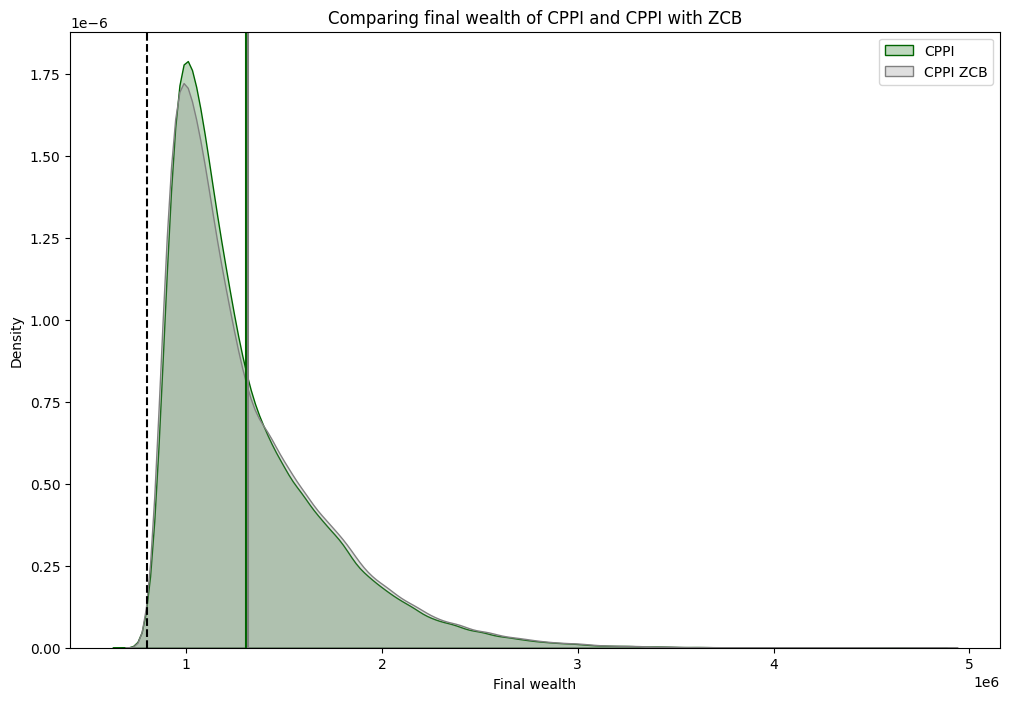

In [86]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(cppi_strat_mv[:, -1], color="darkgreen", alpha=0.25, label="CPPI", fill=True)
sns.kdeplot(cppi_strat_mv_w_zcb[:, -1], color="gray", alpha=0.25, label="CPPI ZCB", fill=True)

ax.axvline(x=cppi_strat_mv[:, -1].mean(), color="darkgreen")
ax.axvline(x=cppi_strat_mv_w_zcb[:, -1].mean(), color="gray")

ax.axvline(x=8e5, color="black", linestyle='--')

ax.set(xlabel="Final wealth", title="Comparing final wealth of CPPI and CPPI with ZCB")

ax.legend();

### The effect of rebalancing frequency

Descreasing the rebalancing frequency will increase the probability of not realizing at least the amount we want to protect.

In [87]:
"""
Increase the multiplier of the CPPI ZCB strategy
"""

h_risky_w_zcb, h_risk_free_w_zcb, cppi_strat_mv_w_zcb, cush_cppi_w_zcb = calculate_cppi_strategy(multiplier=5,
                                                                              floor=8e5,
                                                                              v=asset_prices_w_zcb,
                                                                              initial_market_value=1e6,
                                                                              leverage_constraint=1.0,
                                                                              scale_floor=True, 
                                                                              scale=zcb_mv)

In [88]:
"""
Simulate monthly values of the risky asset into the future 
"""

sigma = 0.15
mu = 0.06

num_sim = 100000
dt = 1.0 / 12.0
horizon = 5.0 
num_time_steps = int(horizon / dt)
time_points = np.arange(0, num_time_steps + 1, 1) * dt

risky_log_ret = np.random.normal(loc=(mu - 0.5 * sigma**2) * dt,
                                 scale=sigma * np.sqrt(dt),
                                 size=(num_sim, num_time_steps))

monthly_risky_mv = np.c_[np.ones(num_sim), np.exp(np.cumsum(risky_log_ret, axis=1))]

In [89]:
"""
Simulate monthly values of the risk free rate into the future 
"""

initial_rate = 0.03
kappa = 1.0
theta = 0.03
beta = 0.02

monthly_short_rates = simulate_vasicek(initial_short_rate=initial_rate,
                               kappa=kappa,
                               theta=theta,
                               beta=beta,
                               horizon=horizon, 
                               dt=dt,
                               num_sim=num_sim)


monthly_bank_account_mv = np.c_[np.ones(num_sim), np.exp(np.cumsum(monthly_short_rates[:, :-1]*dt, axis=1))]

In [90]:
"""
Calculate monthly ZCB values into the future
"""
monthly_zcb_mv = np.zeros_like(monthly_bank_account_mv)
for i, t in enumerate(time_points):
    monthly_zcb_mv[:, i] = calculate_zero_coupon_price(5.0 - t, monthly_short_rates[:, i], kappa, theta, beta, rp)

In [91]:
"""
Define array of asset prices
"""

initial_mv = 1_000_000

# define asset universe
monthly_asset_prices =   np.zeros((num_sim, num_time_steps + 1, 2))
monthly_asset_prices[:, :, 0] = monthly_risky_mv  
monthly_asset_prices[:, :, 1] = monthly_zcb_mv / monthly_zcb_mv[0, 0]

In [92]:
"""
Monthly CPPI strategy with monthly rebalancing and a multiplier of 5
"""

monthly_h_risky_w_zcb, monthly_h_risk_free_w_zcb, monthly_cppi_strat_mv_w_zcb, monthly_cush_cppi_w_zcb = calculate_cppi_strategy(multiplier=5,
                                                                              floor=8e5,
                                                                              v=monthly_asset_prices,
                                                                              initial_market_value=1e6,
                                                                              leverage_constraint=1.0,
                                                                              scale_floor=True, 
                                                                              scale=monthly_zcb_mv)

In [93]:
"""
A small likelihood of not realizing the amount to be protected. 
"""

np.mean(monthly_cppi_strat_mv_w_zcb[:, -1] <=8e5)

1e-05

In [94]:
monthly_cppi_strat_mv_w_zcb[:, -1].min()

794794.646491077

In [95]:
"""
"Zero" probability with the weekly strategy
"""

np.mean(cppi_strat_mv_w_zcb[:, -1] < 8e5)

0.0

In [96]:
cppi_strat_mv_w_zcb[:, -1].min()

800195.8213891785

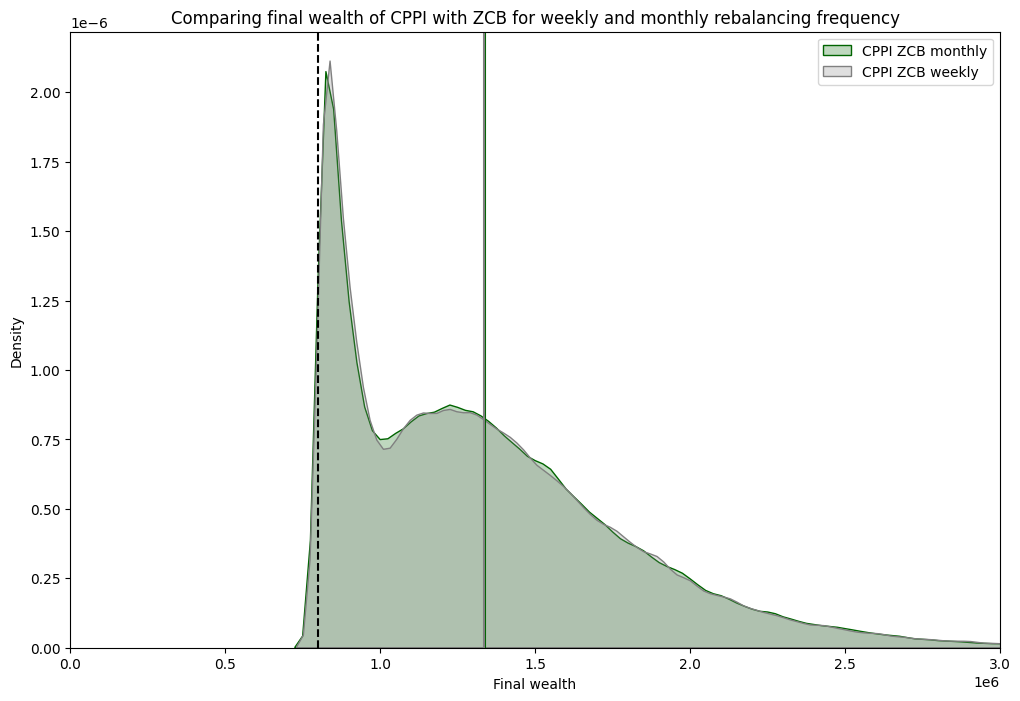

In [97]:
"""
Plot pay off profile
"""

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(monthly_cppi_strat_mv_w_zcb[:, -1], color="darkgreen", alpha=0.25, label="CPPI ZCB monthly", fill=True,bw_adjust=.5)
sns.kdeplot(cppi_strat_mv_w_zcb[:, -1], color="gray", alpha=0.25, label="CPPI ZCB weekly", fill=True, bw_adjust=.5)

ax.axvline(x=monthly_cppi_strat_mv_w_zcb[:, -1].mean(), color="darkgreen")
ax.axvline(x=cppi_strat_mv_w_zcb[:, -1].mean(), color="gray")

ax.axvline(x=8e5, color="black", linestyle='--')

ax.set_xlim([0.0, 3e6])

ax.set(xlabel="Final wealth", title="Comparing final wealth of CPPI with ZCB for weekly and monthly rebalancing frequency")

ax.legend();